In [4]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(threshold=np.inf)
from numpy import fft

In [2]:
def bounds_hzf(upleft, hunit, wunit):
    up = upleft[0]
    left = upleft[1]
    down = up + hunit
    right = left + wunit
    return up, down, left, right

In [3]:
def patchify_hand(img, hsize, wsize, hstep, wstep, goback=0):  # goback=0 means 12->23->34; goback=1 means 12->23->34->41.
    height, width = img.shape
    if not goback:
        hamount, wamount = int((height-hsize)/hstep)+1, int((width-wsize)/wstep)+1
        all_patches = np.zeros((hamount, wamount, hsize, wsize))
        for i in range(0, hamount):
            for j in range(0, wamount):
                u, d, l, r = bounds_hzf((i*hstep, j*wstep), hsize, wsize)
                all_patches[i, j, :, :] = img[u:d, l:r]
    else:
        newh, neww = height+hsize-hstep, width+wsize-wstep
        extend_img = np.zeros((newh, neww))
        extend_img[0:height, 0:width] = img[:, :]
        extend_img[height:newh, 0:width] = img[0:(newh-height), :]
        extend_img[0:height, width:neww] = img[:, 0:(neww-width)]
        extend_img[height:newh, width:neww] = img[0:(newh-height), 0:(neww-width)]
        hamount, wamount = int(height/hstep), int(width/wstep)
        all_patches = np.zeros((hamount, wamount, hsize, wsize))
        for i in range(0, hamount):
            for j in range(0, wamount):
                u, d, l, r = bounds_hzf((i*hstep, j*wstep), hsize, wsize)
                all_patches[i, j, :, :] = extend_img[u:d, l:r]
    return all_patches


def unpatchify_hand(pch, hsize, wsize, hstep, wstep, mode, goback=0):  # goback=0 means 12->23->34; goback=1 means 12->23->34->41.
    if mode=='avg':
        hamount, wamount = pch.shape[0], pch.shape[1]
        if not goback:
            height, width = int((hamount-1)*hstep+hsize), int((wamount-1)*wstep+wsize)
            merged_img = np.zeros((height, width))
            for i in range(0, hamount):
                for j in range(0, wamount):
                    u, d, l, r = bounds_hzf((i*hstep, j*wstep), hsize, wsize)
                    merged_img[u:d, l:r] = merged_img[u:d, l:r] + pch[i, j, :, :]
        else:
            height, width = int(hamount*hstep), int(wamount*wstep)
            hamount_true, wamount_true = hamount-int(hsize/hstep)+1, wamount-int(wsize/wstep)+1
            merged_img = np.zeros((height, width))
            for i in range(0, hamount_true):
                for j in range(0, wamount_true):
                    u, d, l, r = bounds_hzf((i*hstep, j*wstep), hsize, wsize)
                    merged_img[u:d, l:r] = merged_img[u:d, l:r] + pch[i, j, :, :]
        blockh, blockw, ratio = int(height/hstep), int(width/wstep), int(hsize/hstep)
        def getdeno_hzf(hbound, wbound, hlocate, wlocate, ratio):
            hdist = min(hlocate+1, hbound-hlocate)
            wdist = min(wlocate+1, wbound-wlocate)
            mulhw = hdist*wdist
            return min(mulhw, min(hdist,wdist)*ratio, ratio**2)
        for ij in range(0, blockh):
            for ji in range(0, blockw):
                uu, dd, ll, rr = bounds_hzf((ij*hstep, ji*wstep), hstep, wstep)
                merged_img[uu:dd, ll:rr] = merged_img[uu:dd, ll:rr] / getdeno_hzf(blockh, blockw, ij, ji, ratio)          
    elif mode=='firstin':
        hamount, wamount = pch.shape[0], pch.shape[1]
        if not goback:
            height, width = int((hamount-1)*hstep+hsize), int((wamount-1)*wstep+wsize)
            merged_img = np.zeros((height, width))
            merged_img.fill(-np.inf)  # pixel values must be non-negative
            for i in range(0, hamount):
                for j in range(0, wamount):
                    u, d, l, r = bounds_hzf((i*hstep, j*wstep), hsize, wsize)
                    for zifei in range(u, d, 1):
                        for han in range(l, r, 1):
                            if merged_img[zifei, han]<0:
                                merged_img[zifei, han] = pch[i, j, zifei-u, han-l]
        else:
            height, width = int(hamount*hstep), int(wamount*wstep)
            hamount_true, wamount_true = hamount-int(hsize/hstep)+1, wamount-int(wsize/wstep)+1
            merged_img = np.zeros((height, width))
            merged_img.fill(-np.inf)  # pixel values must be non-negative
            for i in range(0, hamount_true):
                for j in range(0, wamount_true):
                    u, d, l, r = bounds_hzf((i*hstep, j*wstep), hsize, wsize)
                    for zifei in range(u, d, 1):
                        for han in range(l, r, 1):
                            if merged_img[zifei, han]<0:
                                merged_img[zifei, han] = pch[i, j, zifei-u, han-l]

    return merged_img

In [4]:
img = np.load('0685.npy')
ret = patchify_hand(img, 64, 64, 16, 16)
print(ret.shape)

(107, 107, 64, 64)


True

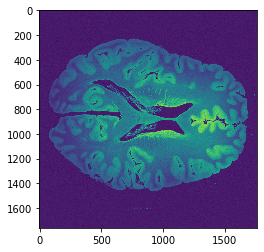

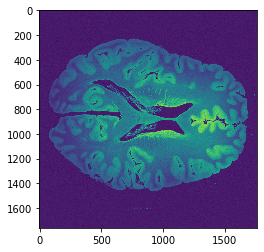

In [5]:
brave_new_world = unpatchify_hand(ret, 64, 64, 16, 16, 'firstin')
plt.figure()
plt.imshow(brave_new_world)
plt.figure()
plt.imshow(img)
np.allclose(brave_new_world, img)

In [7]:
from scipy.io import loadmat
addr = './Mat/mprage.mat'
# s = loadmat(addr)
import mat73
data_dict = mat73.loadmat(addr)['anatRef']

In [8]:
np.save('./T2_data/whole_set.npy',data_dict)

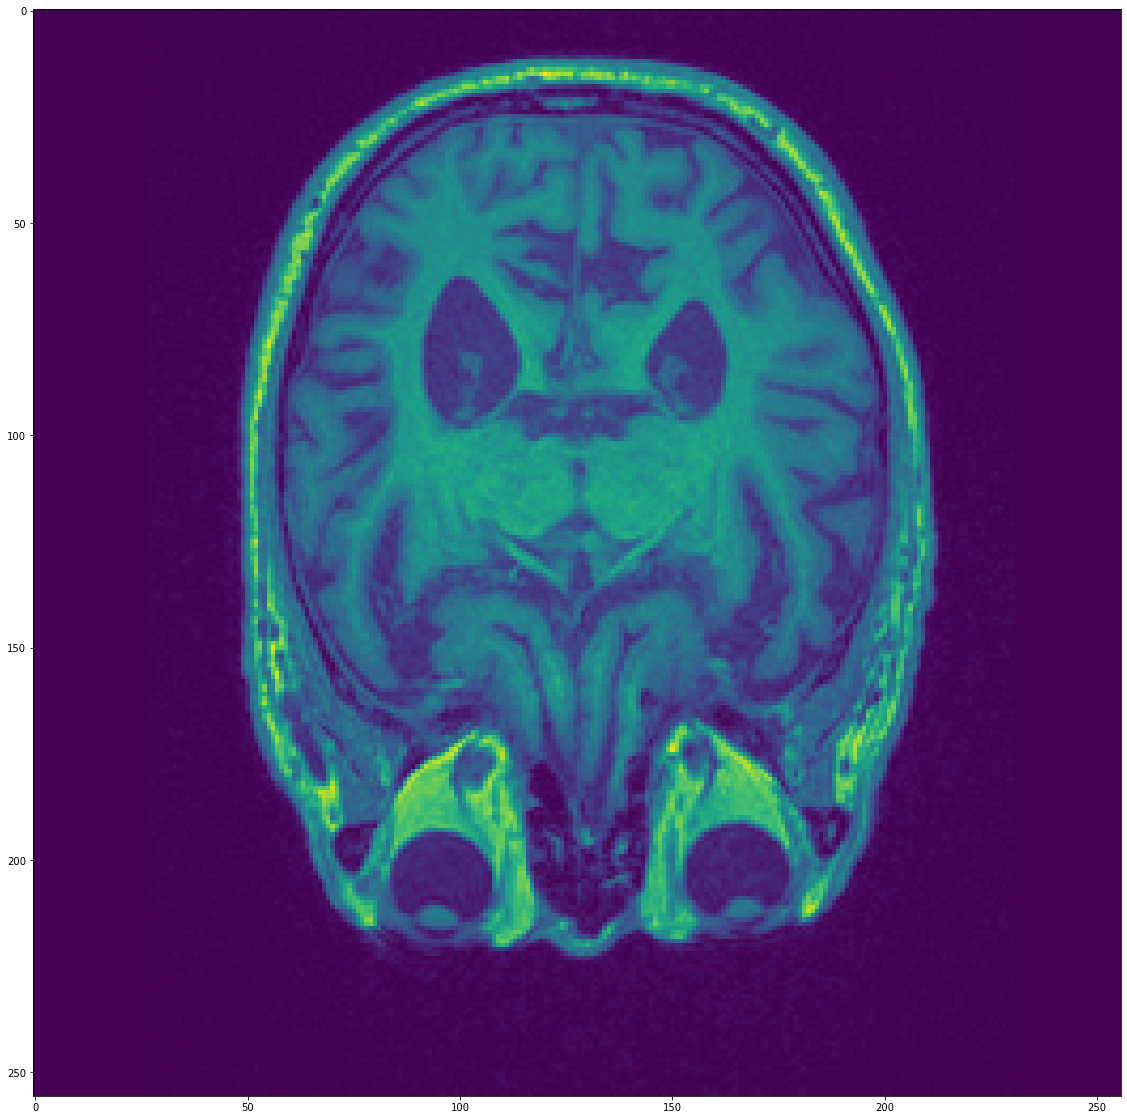

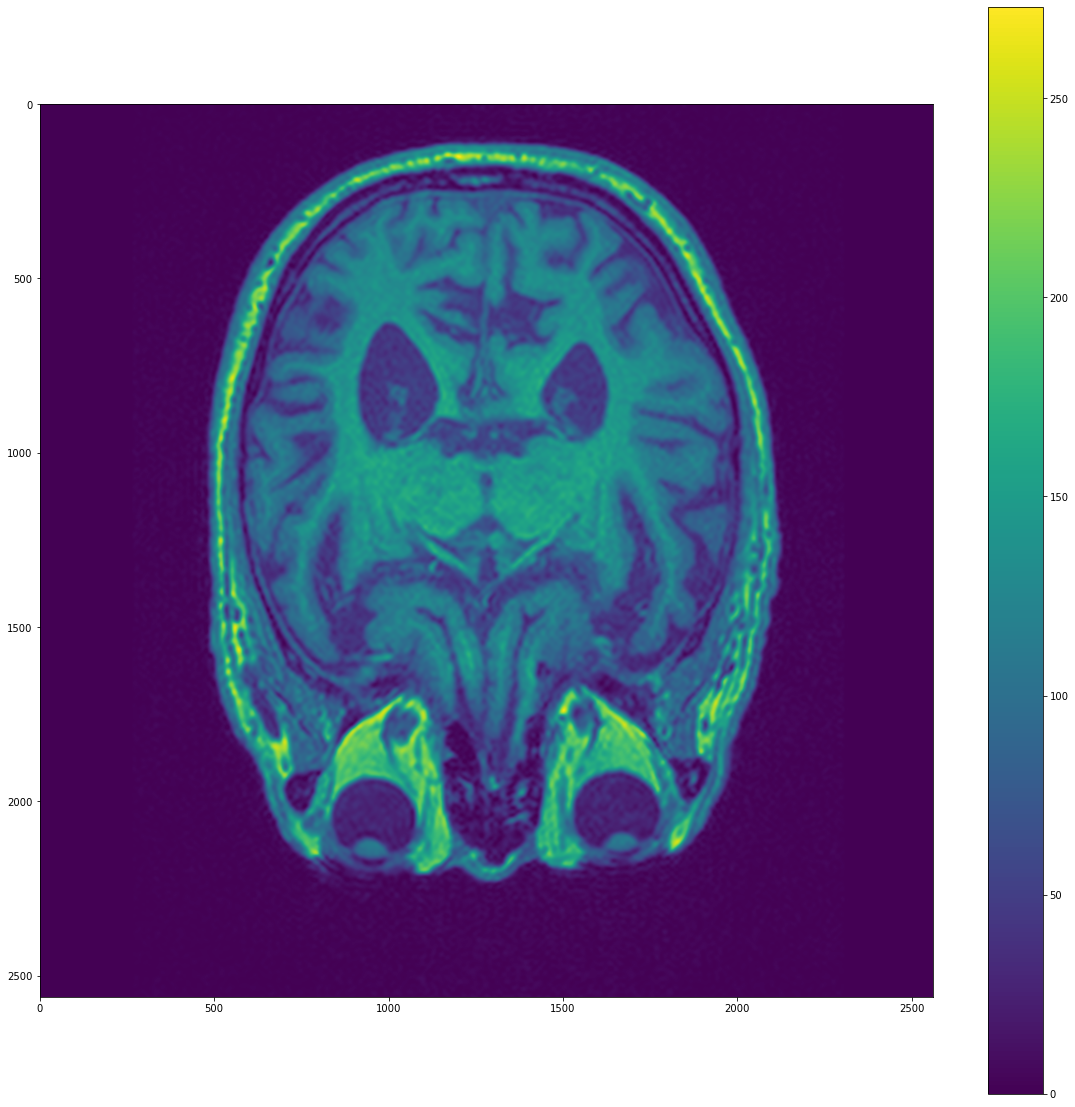

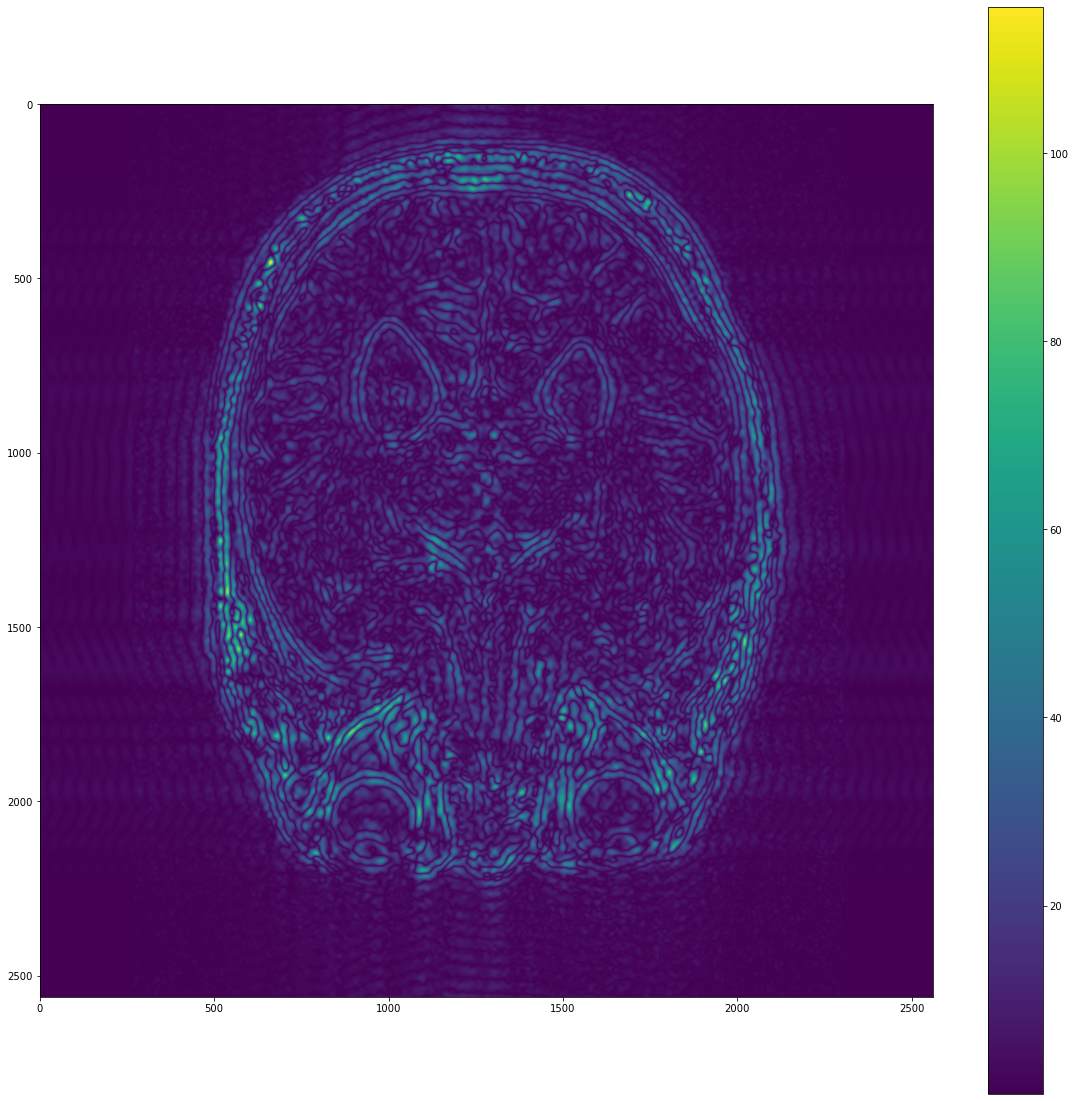

In [13]:
low_img = data_dict[:,:,24]
plt.figure(figsize=(20,20))
plt.imshow(low_img)
fft_img = fft.fftshift(fft.fft2(low_img))
new_fft = np.zeros((2560,2560),dtype=complex)
new_fft[1281-128:1281+128,1281-128:1281+128] = fft_img

# edge_fft = new_fft.copy()
# edge_fft[1281-32:1281+32,1281-32:1281+32] = np.zeros((64,64),dtype=complex)

new_fft = fft.fftshift(new_fft)
new_img = fft.ifft2(new_fft)

new_img = new_img/np.max(new_img)*255
fft_img = fft.fftshift(fft.fft2(new_img))
edge_fft = fft_img.copy()
edge_fft[1281-32:1281+32,1281-32:1281+32] = np.zeros((64,64),dtype=complex)

edge_fft = fft.fftshift(edge_fft)
new_edge = fft.ifft2(edge_fft)

plt.figure(figsize=(20,20))
plt.imshow(abs(new_img))
plt.colorbar()
np.save('./T2_data/new_image24.npy',new_img)

plt.figure(figsize=(20,20))
plt.imshow(abs(new_edge))
plt.colorbar()
np.save('./T2_data/new_edge24.npy',new_edge)